## Baseline
### Рекомендации с основой на жанровое сходство книг (Jaccard similarity) и популярность
**Пока:**
- Предобработали данные, создали словари, добавили кэширование для ускорения работы
- Сделали гибридную модель скоринга (w1*Jaccard + w2*popularity), так же сделали адаптивные веса для популярности (пользователь читает чаще популярные книги -> больше вес для популярности во время скоринга)
- Протестировали на разном допустимом количестве прочитанных книг у пользовател и количестве рекомендуемых книг: min_interactions >= x, in [30, 50, 70, 100], with corresponding top_n in [9, 15, 21, 30] (0.3 * min_interactions)
- Для каждого теста рандомно выбираются 100 пользователей из списка валидных, для них генерируется "train set" - самые первые записи на основе которых подбираются top_n рекомендаций, "test set" - то с чем рекомендации сравниваются
- Вычислили Hit Rate, визуализировали распределение, сохранили статистику, замерили время подбора рекомендаций

**Далее:**
- Больше тестировать (разное количество пользователей и разное количество книг в истории)
- Собрать больше метрик (количество хитов довольно мало, попробуем посмотреть на данные "оценим своими глазами", попробуем другие метрики)

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Data preparation

In [43]:
interactions = pd.read_csv('data/interactions.csv')
items = pd.read_csv('data/items.csv')
users = pd.read_csv('data/users.csv')

In [44]:
def preprocess_items(items_df):
    
    items_processed = items_df.copy()

    items_processed['genres_list'] = items_processed['genres'].fillna('').apply(
        lambda x: [genre.strip() for genre in str(x).split(',') if genre.strip() and genre.strip() != 'nan']
    )
    
    items_processed['authors_list'] = items_processed['authors'].fillna('').apply(
        lambda x: [author.strip() for author in str(x).split(',') if author.strip() and author.strip() != 'nan']
    )
    
    def clean_year(year_value):
        if pd.isna(year_value):
            return np.nan
        
        year_str = str(year_value).strip()
        
        if not year_str:
            return np.nan
        
        try:
            year_num = int(float(year_str))
            if year_num <= 2025:
                return year_num
            else:
                return np.nan
        except ValueError:
            return np.nan
    
    items_processed['year_clean'] = items_processed['year'].apply(clean_year)
    
    
    return items_processed
def preprocess_interactions(interactions_df):
    
    interactions_processed = interactions_df.copy()
    
    interactions_processed['start_date_dt'] = pd.to_datetime(interactions_processed['start_date'])
    
    interactions_processed['start_year'] = interactions_processed['start_date_dt'].dt.year
    interactions_processed['start_month'] = interactions_processed['start_date_dt'].dt.month
    interactions_processed['start_day_of_week'] = interactions_processed['start_date_dt'].dt.dayofweek
    interactions_processed['start_quarter'] = interactions_processed['start_date_dt'].dt.quarter
    interactions_processed['is_weekend'] = interactions_processed['start_day_of_week'].isin([5, 6]).astype(int)
    
    def categorize_progress(progress):
        if progress == 0:
            return 'not_started'
        elif progress < 25:
            return 'barely_started'
        elif progress < 50:
            return 'quarter_read'
        elif progress < 75:
            return 'half_read'
        elif progress < 100:
            return 'almost_finished'
        else:
            return 'completed'
    
    interactions_processed['progress_category'] = interactions_processed['progress'].apply(categorize_progress)
    
    interactions_processed['season'] = interactions_processed['start_month'].map({
        12: 'winter', 1: 'winter', 2: 'winter',
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'autumn', 10: 'autumn', 11: 'autumn'
    })
    
    
    return interactions_processed

In [45]:
interactions = preprocess_interactions(interactions)
items = preprocess_items(items)

In [77]:
def prepare(interactions: pd.DataFrame, items: pd.DataFrame, min_interactions = 50):
    interactions_cp = interactions.copy()
    items_cp = items.copy()

    book_count = interactions_cp.groupby('user_id').size()
    valid_users = book_count[book_count >= min_interactions].index
    print(f"Users with с >= {min_interactions} 'readed books': {len(valid_users)}")
    print(f"Total number of users: {len(book_count)}")

    filtered_interactions = interactions_cp[interactions_cp['user_id'].isin(valid_users)].copy()
    filtered_interactions = filtered_interactions.sort_values(['user_id', 'start_date_dt'])

    all_genres = set()
    for genres_list in items_cp['genres_list']:
        all_genres.update(genres_list)
    genres_encoding = {genre: idx for idx, genre in enumerate(all_genres)}

    items_cp['genres_list_idx'] = items_cp['genres_list'].apply(lambda x: [genres_encoding[genre] for genre in x])


    items_cp.set_index('id', inplace=True)

    genre_index = {}
    for idx, row in items_cp.iterrows():
        item_id = idx
        genres = row['genres_list_idx']
        for genre in genres:
            if genre not in genre_index:
                genre_index[genre] = []
            genre_index[genre].append(item_id)


    item_to_genres = dict(zip(items_cp.index, items_cp['genres_list_idx']))
    item_to_genres_list = dict(zip(items_cp.index, items_cp['genres_list_idx']))

    return filtered_interactions, items_cp, valid_users, genres_encoding, genre_index, item_to_genres, item_to_genres_list


### Main algorithm

In [47]:
def split_user_history(user_interactions: pd.DataFrame, top_n=15):
    train = user_interactions.iloc[:-top_n]
    test = user_interactions.iloc[-top_n:]
    return train, test

**Weights with exponential decay** (last one have more)

In [48]:
def get_candidates(user_interactions: pd.DataFrame, item_to_genres: dict, genre_index: dict) -> set:

    user_genres = set()
    for item in user_interactions['item_id']:
        item_genres = item_to_genres.get(item, [])
        user_genres.update(item_genres)

    candidate_item_ids = set()
    for genre in user_genres:
        candidate_item_ids.update(genre_index.get(genre, []))

    candidate_item_ids.difference_update(user_interactions['item_id'])

    return candidate_item_ids

In [63]:
weights_cache = {}

def user_interactions_weights(n_books, rate=0.02) -> list:
    if n_books in weights_cache:
        return weights_cache[n_books]

    weights = []
    for idx in range(n_books):
        weight = np.exp(-rate * (n_books - 1 - idx))
        weights.append(weight)

    weights_cache[n_books] = weights
    return weights


popularity_counts_cached = None
max_popularity_cached = None

def adaptive_popularity_weight(user_interactions: pd.DataFrame, 
                              interactions_df: pd.DataFrame) -> float:
    global popularity_counts_cached, max_popularity_cached

    if popularity_counts_cached is None:
        popularity_counts = interactions_df['item_id'].value_counts()
        popularity_counts_cached = popularity_counts
        max_popularity_cached = popularity_counts.max()

    user_books = user_interactions['item_id'].tolist()

    user_avg_popularity = np.mean([popularity_counts_cached.get(book, 0) for book in user_books])
    max_popularity = max_popularity_cached
    
    # if user reads more popular books -> popularity weight increase
    normalized_user_pop = user_avg_popularity / max_popularity
    
    return min(0.5, normalized_user_pop)  # limit

In [64]:
def jaccard_similarity_inverted(list1: list, list2: list) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0


def weighted_jaccard_score(user_interactions: pd.DataFrame, candidate_item_id: int, item_to_genres: dict, decay_rate: float = 0.02) -> float:
    candidate_genres = item_to_genres.get(candidate_item_id, [])

    if not isinstance(candidate_genres, list):
        return 0.0

    result_score = 0.0
    result_weight = 0.0
    weights = user_interactions_weights(user_interactions.shape[0], rate=decay_rate)

    item_ids = user_interactions['item_id'].values

    for idx, item_id in enumerate(item_ids):
        user_genres = item_to_genres.get(item_id, [])
        if not user_genres:
            continue

        jaccard_sim = jaccard_similarity_inverted(candidate_genres, user_genres)

        result_score += jaccard_sim * weights[idx]
        result_weight += weights[idx]

    # normalization by total weight
    return result_score / result_weight if result_weight > 0 else 0.0

max_popularity = 0

popularity_cache = {}

def compute_popularity_score(item_id: int, interactions_df: pd.DataFrame) -> float:
    global popularity_counts_cached, max_popularity_cached
    if item_id in popularity_cache:
        return popularity_cache[item_id]

    if popularity_counts_cached is None:
        popularity_counts = interactions_df['item_id'].value_counts()
        popularity_counts_cached = popularity_counts
        max_popularity_cached = popularity_counts.max()

    item_popularity = popularity_counts_cached.get(item_id, 0)

    max_popularity = max_popularity_cached
    score = item_popularity / max_popularity if max_popularity > 0 else 0
    popularity_cache[item_id] = score
    return score

def hybrid_weighted_score(user_interactions: pd.DataFrame, candidate_item_id: int, interactions_df: pd.DataFrame, item_to_genres: dict, jaccard_weight=0.7, popularity_weight=0.3, decay_rate=0.02) -> float:

    jaccard_score = weighted_jaccard_score(user_interactions, candidate_item_id, item_to_genres, decay_rate=decay_rate)

    popularity_score = compute_popularity_score(candidate_item_id, interactions_df)
    
    final_score = (jaccard_weight * jaccard_score + 
                   popularity_weight * popularity_score)
    
    return final_score




In [65]:
def recommend_items(user_interactions: pd.DataFrame, interactions_df: pd.DataFrame, item_to_genres: dict, genre_index: dict, top_n=10, decay_rate=0.02) -> list[tuple[int, float]]:
    candidate_items = get_candidates(user_interactions, item_to_genres, genre_index)


    popularity_weight = adaptive_popularity_weight(user_interactions, interactions_df)
    jaccard_weight = 1 - popularity_weight

    scores = []
    for item_id in candidate_items:
        hybrid_score = hybrid_weighted_score(user_interactions, item_id, interactions_df, item_to_genres, jaccard_weight, popularity_weight, decay_rate=decay_rate)
        scores.append((item_id, hybrid_score))

    scores.sort(key=lambda x: x[1], reverse=True) 

    return scores[:top_n]

In [66]:
def recommender(interactions_df: pd.DataFrame, filtered_interactions_df: pd.DataFrame, item_to_genres: dict, genre_index: dict, valid_users: np.ndarray, top_n=10, select_n=100, decay_rate=0.02) -> pd.DataFrame:

    selected_users = np.random.choice(valid_users, size=select_n, replace=False).tolist()
    results = []

    for user_id in tqdm(selected_users, desc="Users processed"):
        user_interactions = filtered_interactions_df[filtered_interactions_df['user_id'] == user_id]
        train, test = split_user_history(user_interactions, top_n=top_n)

        recommended = recommend_items(train, interactions_df, item_to_genres, genre_index, top_n=top_n, decay_rate=decay_rate)
        recommended_item_ids = set([item_id for item_id, score in recommended])
        scores = [score for item_id, score in recommended]

        actual_item_ids = set(test['item_id'])
        previous_item_ids = train['item_id']

        hits = recommended_item_ids.intersection(actual_item_ids)

        results.append({
            'user_id': user_id,
            'previous_item_ids': list(previous_item_ids),
            'recommended_item_ids': list(recommended_item_ids),
            'actual_item_ids': list(actual_item_ids),
            'hits': list(hits),
            'scores': scores
        })

    recommendations = pd.DataFrame(results)
    return recommendations

In [67]:
np.random.seed(42)
top_n = 15
decay_rate = 0.02
min_interactions = 50

In [68]:
filtered_interactions, items_cp, valid_users, genres_encoding, genre_index, item_to_genres, item_to_genres_list = prepare(interactions, items, min_interactions=min_interactions)

Users with с >= 50 'readed books': 2542
Total number of users: 151600


In [69]:
recommendations = recommender(interactions, filtered_interactions, item_to_genres, genre_index, valid_users, top_n=top_n, select_n=100, decay_rate=decay_rate)

Users processed: 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


In [70]:
recommendations

,user_id,previous_item_ids,recommended_item_ids,actual_item_ids,hits,scores
0,102557,"[202166, 27599, 147676, 40236, 196913, 92867, ...","[14145, 22083, 10568, 55913, 2281, 21450, 2627...","[198593, 80195, 61478, 302317, 296205, 312432,...",[161017],"[0.17428164780841013, 0.17329863552958652, 0.1..."
1,46273,"[5697, 217859, 201262, 236876, 319332, 279975,...","[170369, 246146, 257570, 250232, 158851, 28279...","[28864, 49986, 308613, 153032, 215721, 67946, ...",[],"[0.09248667122062833, 0.09228412739325138, 0.0..."
2,32856,"[259241, 125427, 4442, 152378, 148424, 268138,...","[222243, 62788, 218725, 133158, 318694, 283557...","[295936, 320258, 47307, 76429, 157422, 69327, ...",[],"[0.1520098594847235, 0.1494265042357673, 0.149..."
3,90919,"[45266, 305076, 169297, 112312, 252831, 65490,...","[107522, 236904, 197579, 179930, 157422, 10920...","[25633, 267813, 282759, 274761, 223818, 241228...","[4497, 109201]","[0.25206539948869455, 0.2476683432675701, 0.24..."
4,36783,"[97371, 49845, 265809, 16703, 98837, 161454, 1...","[249857, 16291, 197958, 106567, 174541, 187887...","[265984, 135490, 151172, 95814, 7271, 221191, ...",[],"[0.38474513312230507, 0.3842162923841018, 0.38..."
...,...,...,...,...,...,...
95,70885,"[223633, 15169, 15032, 238820, 121391, 159130,...","[182464, 243367, 69064, 85775, 177648, 171667,...","[2028, 88397, 187501, 225135, 75951, 39727, 22...",[],"[0.4093302844051724, 0.4093006717875437, 0.409..."
96,147018,"[259980, 118939, 318418, 189902, 32504, 310587...","[284832, 293824, 19074, 238531, 152708, 136933...","[97954, 50340, 30053, 40997, 296998, 262775, 1...",[],"[0.41381622773424687, 0.4138120831885335, 0.41..."
97,85357,"[11062, 159580, 175906, 109088, 9806, 228424, ...","[244384, 1992, 74474, 301677, 229903, 294290, ...","[145444, 318886, 115389, 296840, 3722, 139916,...",[],"[0.3054614337160102, 0.30519902434692625, 0.30..."
98,82999,"[91955, 231042, 112937, 78244, 247773, 262881,...","[178882, 180291, 207173, 70535, 150442, 6059, ...","[278465, 64259, 21444, 76359, 71527, 318442, 2...",[],"[0.5969785446538359, 0.596773103672484, 0.5967..."


In [71]:
max(len(hits) for hits in recommendations['hits'])

5

In [72]:
np.mean([len(hits) for hits in recommendations['hits']])

np.float64(0.48)

### Analysis and tests

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def calculate_hit_rates(recommendations_df):
    hit_rates = []
    for _, row in recommendations_df.iterrows():
        n_recommended = len(row['recommended_item_ids'])
        n_hits = len(row['hits'])
        hit_rate = n_hits / n_recommended if n_recommended > 0 else 0
        hit_rates.append(hit_rate)
    return hit_rates

def visualize_hit_rate_distribution(recommendations_df, title="Hit Rate Distribution"):
    hit_rates = calculate_hit_rates(recommendations_df)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(hit_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.title(f'{title} - Histogram')
    plt.xlabel('Hit Rate')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(hit_rates)
    plt.title(f'{title} - Box Plot')
    plt.ylabel('Hit Rate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Hit Rate statistics for {title}:")
    print(f"   Average Hit Rate: {np.mean(hit_rates):.4f}")
    print(f"   Median Hit Rate: {np.median(hit_rates):.4f}")
    print(f"   Std Hit Rate: {np.std(hit_rates):.4f}")
    print(f"   % of users with hits: {(np.array(hit_rates) > 0).mean() * 100:.2f}%")
    print(f"   Maximum Hit Rate: {np.max(hit_rates):.4f}")
    
    return hit_rates


In [82]:
import time


 Testing: min_interactions=30, top_n=9
Users with с >= 30 'readed books': 4685
Total number of users: 151600


Users processed: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]

Recommendation generation took 109.40 seconds.


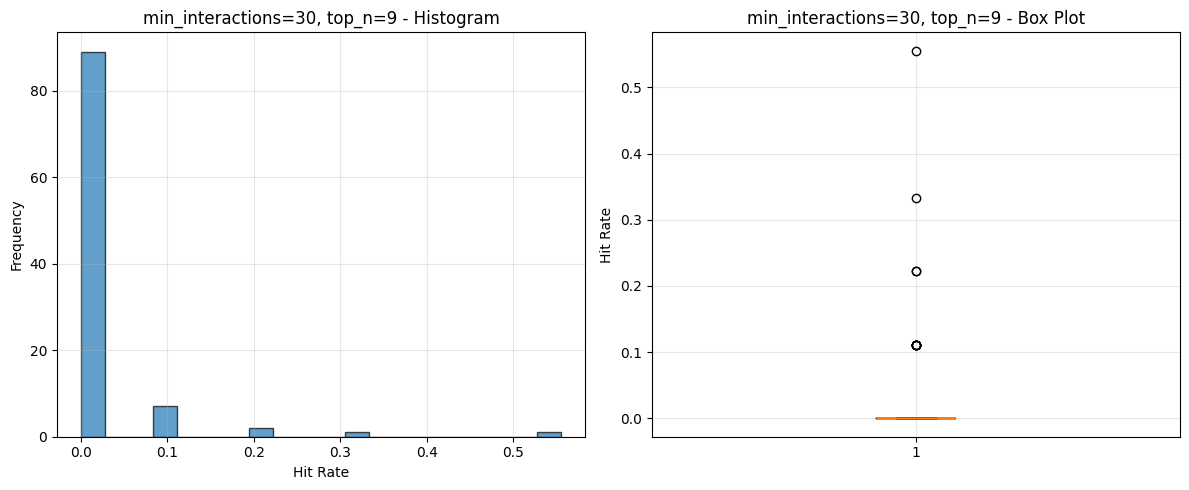

Hit Rate statistics for min_interactions=30, top_n=9:
   Average Hit Rate: 0.0211
   Median Hit Rate: 0.0000
   Std Hit Rate: 0.0749
   % of users with hits: 11.00%
   Maximum Hit Rate: 0.5556
TEST FINISHED for min_interactions=30, top_n=9

 Testing: min_interactions=50, top_n=15
Users with с >= 50 'readed books': 2542
Total number of users: 151600


Users processed: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]

Recommendation generation took 152.42 seconds.


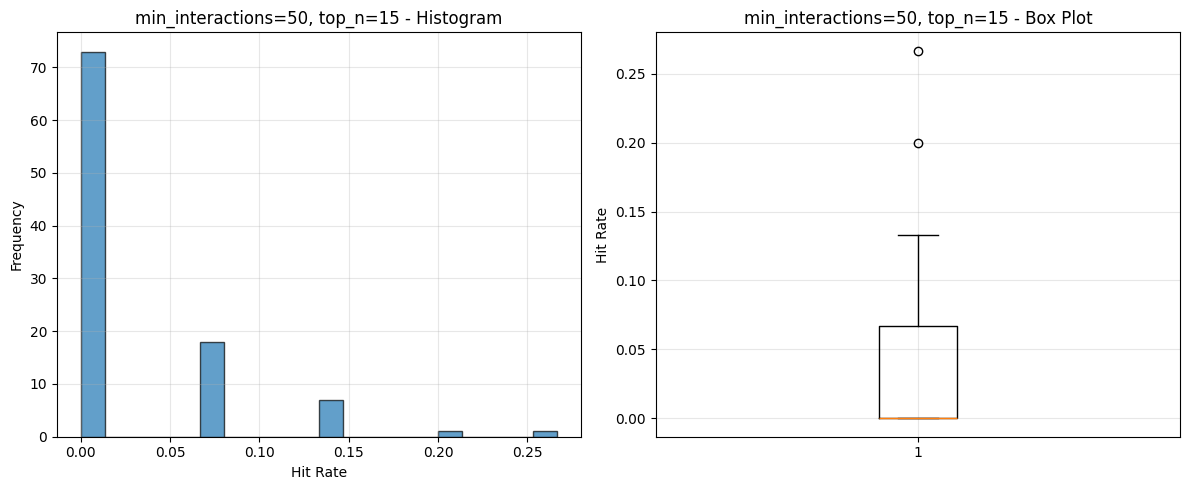

Hit Rate statistics for min_interactions=50, top_n=15:
   Average Hit Rate: 0.0260
   Median Hit Rate: 0.0000
   Std Hit Rate: 0.0498
   % of users with hits: 27.00%
   Maximum Hit Rate: 0.2667
TEST FINISHED for min_interactions=50, top_n=15

 Testing: min_interactions=70, top_n=21
Users with с >= 70 'readed books': 1648
Total number of users: 151600


Users processed: 100%|██████████| 100/100 [03:19<00:00,  2.00s/it]

Recommendation generation took 199.93 seconds.


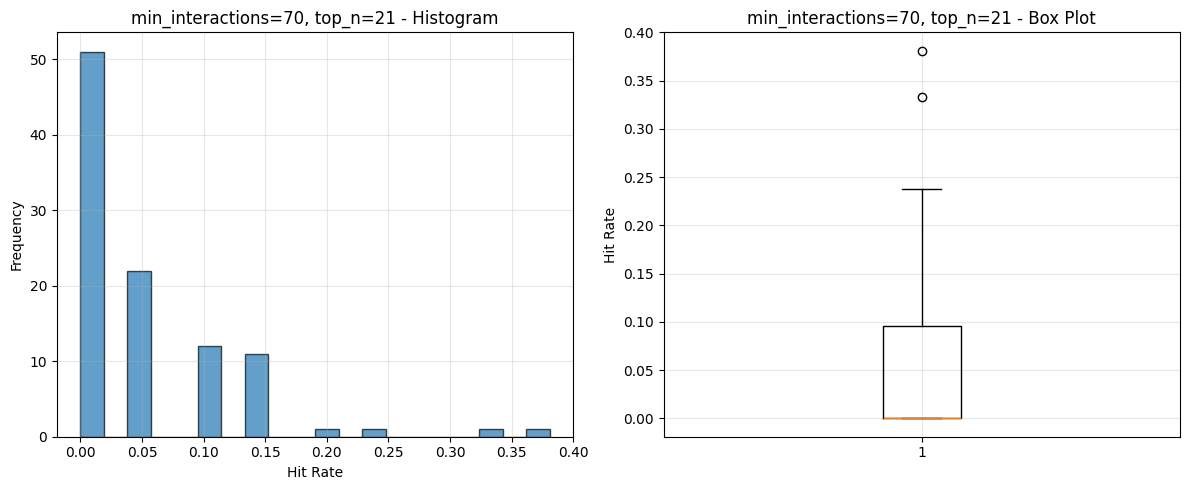

Hit Rate statistics for min_interactions=70, top_n=21:
   Average Hit Rate: 0.0490
   Median Hit Rate: 0.0000
   Std Hit Rate: 0.0701
   % of users with hits: 49.00%
   Maximum Hit Rate: 0.3810
TEST FINISHED for min_interactions=70, top_n=21

 Testing: min_interactions=100, top_n=30
Users with с >= 100 'readed books': 1025
Total number of users: 151600


Users processed: 100%|██████████| 100/100 [04:27<00:00,  2.68s/it]

Recommendation generation took 267.67 seconds.


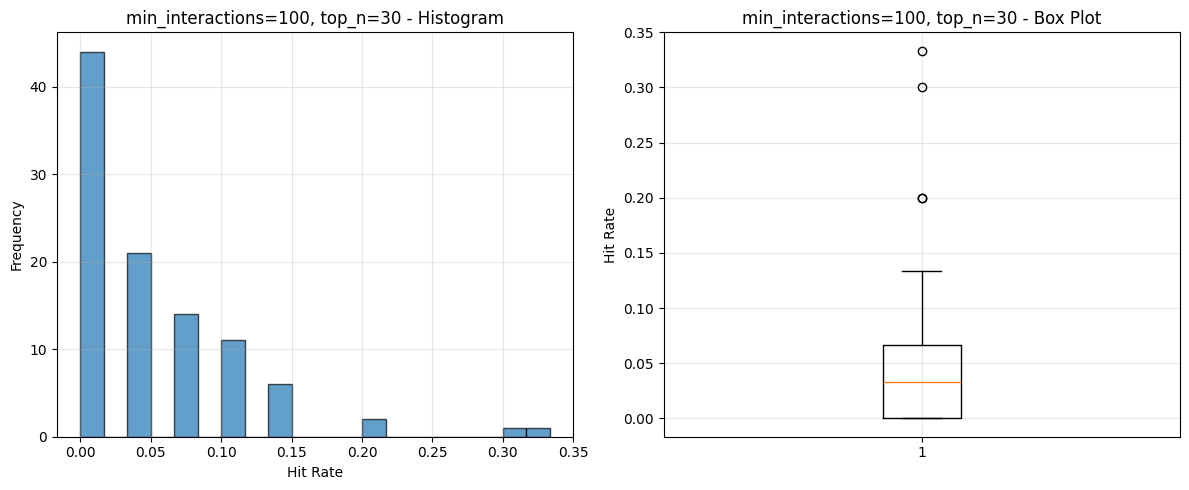

Hit Rate statistics for min_interactions=100, top_n=30:
   Average Hit Rate: 0.0457
   Median Hit Rate: 0.0333
   Std Hit Rate: 0.0612
   % of users with hits: 56.00%
   Maximum Hit Rate: 0.3333
TEST FINISHED for min_interactions=100, top_n=30

 SUMMARY OF RESULTS:
   min_interactions  top_n  n_users  mean_hit_rate  std_hit_rate  \
0                30      9      100         0.0211        0.0749   
1                50     15      100         0.0260        0.0498   
2                70     21      100         0.0490        0.0701   
3               100     30      100         0.0457        0.0612   

   users_with_hits_%  
0               11.0  
1               27.0  
2               49.0  
3               56.0  


In [83]:
def run_parameter_tests(interactions_df, items_df, min_interactions_list=[30, 50, 70, 100], 
                       top_n_list=[9, 15, 21, 30], select_n=100, decay_rate=0.02):
    
    results_summary = []
    
    for min_interactions, top_n in zip(min_interactions_list, top_n_list):
        print(f"\n Testing: min_interactions={min_interactions}, top_n={top_n}")
        print("="*60)

        filtered_interactions, items_cp, valid_users, genres_encoding, genre_index, item_to_genres, _ = prepare(
            interactions_df, items_df, min_interactions=min_interactions
        )

        # cache cleaning
        global popularity_counts_cached, max_popularity_cached, popularity_cache, weights_cache
        popularity_counts_cached = None
        max_popularity_cached = None
        popularity_cache.clear()
        weights_cache.clear()

        start = time.time()

        recommendations = recommender(
            interactions_df, filtered_interactions, item_to_genres, genre_index, 
            valid_users, top_n=top_n, select_n=select_n, decay_rate=decay_rate
        )

        end = time.time()
        print(f"Recommendation generation took {end - start:.2f} seconds.")

        title = f"min_interactions={min_interactions}, top_n={top_n}"
        hit_rates = visualize_hit_rate_distribution(recommendations, title)
        
        results_summary.append({
            'min_interactions': min_interactions,
            'top_n': top_n,
            'n_users': len(recommendations),
            'mean_hit_rate': np.mean(hit_rates),
            'std_hit_rate': np.std(hit_rates),
            'users_with_hits_%': (np.array(hit_rates) > 0).mean() * 100,
        })
        
        print(f"TEST FINISHED for min_interactions={min_interactions}, top_n={top_n}")
    
    summary_df = pd.DataFrame(results_summary)
    print(f"\n SUMMARY OF RESULTS:")
    print("="*80)
    print(summary_df.round(4))
    
    return summary_df


parameter_results = run_parameter_tests(
    interactions, items, 
    min_interactions_list=[30, 50, 70, 100], 
    top_n_list=[9, 15, 21, 30],
    select_n=100,
    decay_rate=0.02
)

### Iterations
- 1: Simple Jaccard with same weights for books
- 2: Added exponential weights to the books in 'train' set of user interactions
- 3: Hybrid scoring, added popularity and adaprive weights for users
- 4: Optimization: caching, dicts, data access optimization
- 5: Testing

#### Next
### Content-based using item vectors